In [1]:
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import Lars

import warnings
warnings.filterwarnings("ignore")

### Generate a dataset of signals and binary labels 

In [2]:
class SyntheticSignals():
    def __init__(self, A, B, n, m, s, s_sigma = 0.5, eps_sigma = 0.01, size = 1000, batch_size = 400):
        
        self.n = n          # Number of samples in the original signal
        self.m = m          # Number of samples through the linear transformation

        self.size = size    # Size of the dataset

        self.alpha = torch.zeros(self.size, self.n)          # Underlying sparse vector 
        self.x = torch.zeros(self.size, self.m)              # Observation
        self.y = torch.zeros(self.size)                      # Binary label 

        self.A = A          # Matrix for the linear observation - Label 0
        self.B = B          # Matrix for the linear observation - Label 1
        self.s = s          # Sparsity of the signal

        self.s_sigma = s_sigma
        self.eps_sigma = eps_sigma

        self.batch_size = batch_size

        # Generating the dataset
        self.set_data()


    def set_tuple(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        idxs = np.random.choice(self.m, self.s, replace=False)
        peaks = np.random.normal(scale=self.s_sigma, size = self.s)
        y_ = np.random.choice([0,1])
        
        # Generating the original signal and its corrupted observations according to a label
        self.alpha[i, idxs] = torch.from_numpy(peaks).to(self.alpha)
        self.x[i,:] = (self.A * (y_ == 1) + self.B * (y_ == 0)) @ self.alpha[i,:]
        self.y[i] = y_

    def set_data(self):
        for i in range(self.size):
            self.set_tuple(i)
    
    
    def set_loader(self):

        # We need tuples observation/label
        return Data.DataLoader(dataset = Data.TensorDataset(self.x, self.y),
                               batch_size = self.batch_size,
                               shuffle = True)

___________________

### Model definition

In [3]:
class TDDL(nn.Module):
    def __init__(self, 
                 M, 
                 P, 
                 K, 
                 train_set,
                 sparsity_mode = 'Deterministic',
                 dicup = True,
                 Lambda = 0.15, 
                 Lambda_2 = 1e-5,
                 burn_in = 10,
                 nu = 1,
                 T = 100, 
                 t_0 = 1, 
                 LR = 5e-03):
        
        super().__init__()

        # Dictionary initialization 
        self.M = M
        self.P = P
        self.D = self.projD(torch.randn((M, P)))

        # Assumed sparsity
        self.K = K
        self.sparsity_mode = sparsity_mode

        # Hyperparameters
        self.Lambda = Lambda
        self.Lambda_2 = Lambda_2
        self.t_0 = t_0
        self.T = T
        self.LR = LR
        self.burn_in = burn_in
        self.nu = nu 

        # Define the linear model W
        self.fc1 = nn.Linear(P, 1)
        torch.nn.init.xavier_uniform(self.fc1.weight)

        # Define the optimization utilities 
        self.criterion = nn.BCEWithLogitsLoss()  

        # Metrics tracker
        self.train_losses = []
        self.eval_losses = []
        self.eval_acc = []
        
        # Initialization
        self.initialization(train_set)

        # Boolean for dictionary update
        self.dicup = dicup

    def initialization(self, train_set):

        # The dictionary is initialized running a certain amount of "warm up" unsupervised optimization steps
        X, Y= next(iter(train_set))
        for _ in tqdm(range(self.burn_in)):
            
            alpha = self.IHT(X)

            with torch.no_grad():
                self.D = self.projD(self.D - self.LR *( - torch.matmul(X.t(), alpha) - torch.matmul(self.D, torch.matmul(alpha.t(), alpha))))
        
        # The parameters of the model are optimized as well once the initialized dictionary is fixed
        for _ in tqdm(range(self.burn_in)):
            alpha = self.IHT(X)
            #L = self.activeSet(alpha)

            # Forward this sparse feature vector enabling gradient computation with respect to the coded sparse vector
            y_hat = self.forward(alpha)

            # Loss computation and backpropagation
            loss = self.criterion(y_hat[:,0], Y)
            loss.backward()

            with torch.no_grad():
                for param in self.parameters():
                    param -= self.LR * (param.grad)
                
    def forward(self, alpha):
        return self.fc1(alpha)
    
    def HT(self, X, K):
            
        # Get the indices of the top K highest magnitude elements for each vector
        _, topk_indices = torch.topk(torch.abs(X), K, dim=1, largest=True)

        # Create a mask to select the top K elements
        mask = torch.zeros_like(X, dtype=torch.bool)
        mask.scatter_(1, topk_indices, 1)

        # Apply the mask to keep the top K highest magnitude components
        X = X * mask

        return X 
      
    def IHT(self, X, var = 3, mu = 3e-1, c = 0.01, max_itr = 100):
        
        if self.sparsity_mode == 'Deterministic':
            K = self.K 
        else:
            K = np.random.randint(self.K - var, self.K + var)

        alpha_hat = torch.zeros(X.shape[0], self.D.shape[1])
        for _ in range(max_itr):

            alpha_tilde = alpha_hat - ((self.D.T @ (alpha_hat @ self.D.T - X).T).T)
            alpha_hat = self.HT(alpha_tilde, K)

        return torch.tensor(alpha_hat, requires_grad=True)
    
    def activeSet(self, alpha):
        return torch.nonzero(alpha, as_tuple=True)

    def projD(self, D):
        
        # We constrain the atoms to have norm at most equal to one
        def projCol(d):
            return d / torch.max(torch.tensor(1.0, device=d.device), torch.linalg.norm(d))

        return D / torch.linalg.norm(D)
        #return torch.stack([projCol(D[:, i]) for i in range(D.shape[1])], dim=1)
    
    def update(self, X, Y):

        # Compute the sparse approximation and its non-zero entries set
        alpha = self.IHT(X)
        L = self.activeSet(alpha)

        # Forward this sparse feature vector enabling gradient computation with respect to the coded sparse vector
        y_hat = self.forward(alpha)

        # Loss computation and backpropagation
        loss = self.criterion(y_hat[:,0], Y)
        loss.backward()

        ##########################
        ### OPTIMIZATION PHASE ###
        ##########################

        # Gradient descent for the model parameters update
        with torch.no_grad():
            for param in self.parameters():
                param -= self.LR * (param.grad)
                

        # Define the auxiliary vector for the D-gradient computation 
        if self.dicup:

            beta = torch.zeros_like(alpha)

            for i in range(alpha.shape[0]):
                active_indices = L[1][L[0] == i]
                dic = self.D[:, active_indices]
                beta[i, active_indices] = torch.matmul(torch.linalg.inv(torch.matmul(dic.t(), dic) + self.Lambda_2 * torch.eye(dic.shape[1])), alpha.grad[i, active_indices])
            
        # Projected gradient descent for the dictionary update
            with torch.no_grad():
                grad_D = - self.D @ torch.matmul(beta.t(), alpha) + torch.matmul((X - torch.matmul(alpha, self.D.t())).t(), beta)
                self.D = self.projD(self.D - self.LR * grad_D)
        
        # Loss tracking
        self.train_losses.append(loss.item())

    def trainLoop(self, train_loader, test_loader = None):
        
        # Set to train mode
        self.train()

        # Main loop
        for _ in tqdm(range(self.T)):
            for X, Y in train_loader:
                self.zero_grad()
                self.update(X, Y)    
            
            if test_loader:
                self.evalLoop(test_loader)

    def evalLoop(self, test_loader, final = False):

        # Set to evaluation mode
        self.eval()
        reconstruction_loss_ = 0

        total_correct = 0
        total_samples = 0
        
        for X, Y in test_loader:

            alpha = self.IHT(X)
            y_hat = self.forward(alpha)
            y_hat = (y_hat > 0.5).float()  
            
            total_correct += (y_hat[:,0] == Y).sum().item()
            total_samples += Y.size(0)

            reconstruction_loss_ += torch.linalg.norm(X.t() - self.D @ alpha.t())

        if final:
            return {
                'Reconstruction error': reconstruction_loss_ / total_samples,
                'Classification accuracy': total_correct / total_samples
                }
        
        else:
            self.eval_losses.append(reconstruction_loss_ / total_samples)
            self.eval_acc.append(total_correct / total_samples)

    def reset(self):
        self.train_losses = []
        self.eval_losses = []
        self.eval_acc = []

In [4]:
# Dimensions for the signal, its sparsity and its observation

m_ = 150
n_ = 200
s_ = 20

# Measurement matrices
A_ = torch.randn(m_,n_)
A_ /= torch.norm(A_, dim=0)

B_ = torch.randn(m_,n_)
B_ /= torch.norm(A_, dim=0)

# Building a training set and a test set 
train_set = SyntheticSignals(A = A_,
                             B = B_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 800).set_loader()

test_set = SyntheticSignals(A = A_,
                            B = B_,
                            n = n_,
                            m = m_,
                            s = s_,
                            size = 200).set_loader()

### Experimenting with different levels of sparsity

In [5]:
Ks = [12,16,20,24,28,32]

models_joint = {k : None for k in Ks}
models_pre = {k : None for k in Ks}

for k in Ks:
    model1 = TDDL(m_, n_, k, train_set, T = 100, LR = 5e-2)
    model1.trainLoop(train_set, test_set)

    model2 = TDDL(m_, n_, k, train_set, dicup = False, burn_in=100, T = 100, LR = 5e-2)
    model2.trainLoop(train_set, test_set)

    models_joint[k] = model1
    models_pre[k] = model2

100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


In [6]:
with open('joint_models.pkl', 'wb') as handle:
    pickle.dump(models_joint, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('pre_models.pkl', 'wb') as handle:
    pickle.dump(models_pre, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('joint_models.pkl', 'rb') as file:
    models_joint = pickle.load(file)

with open('pre_models.pkl', 'rb') as file:
    models_pre = pickle.load(file)

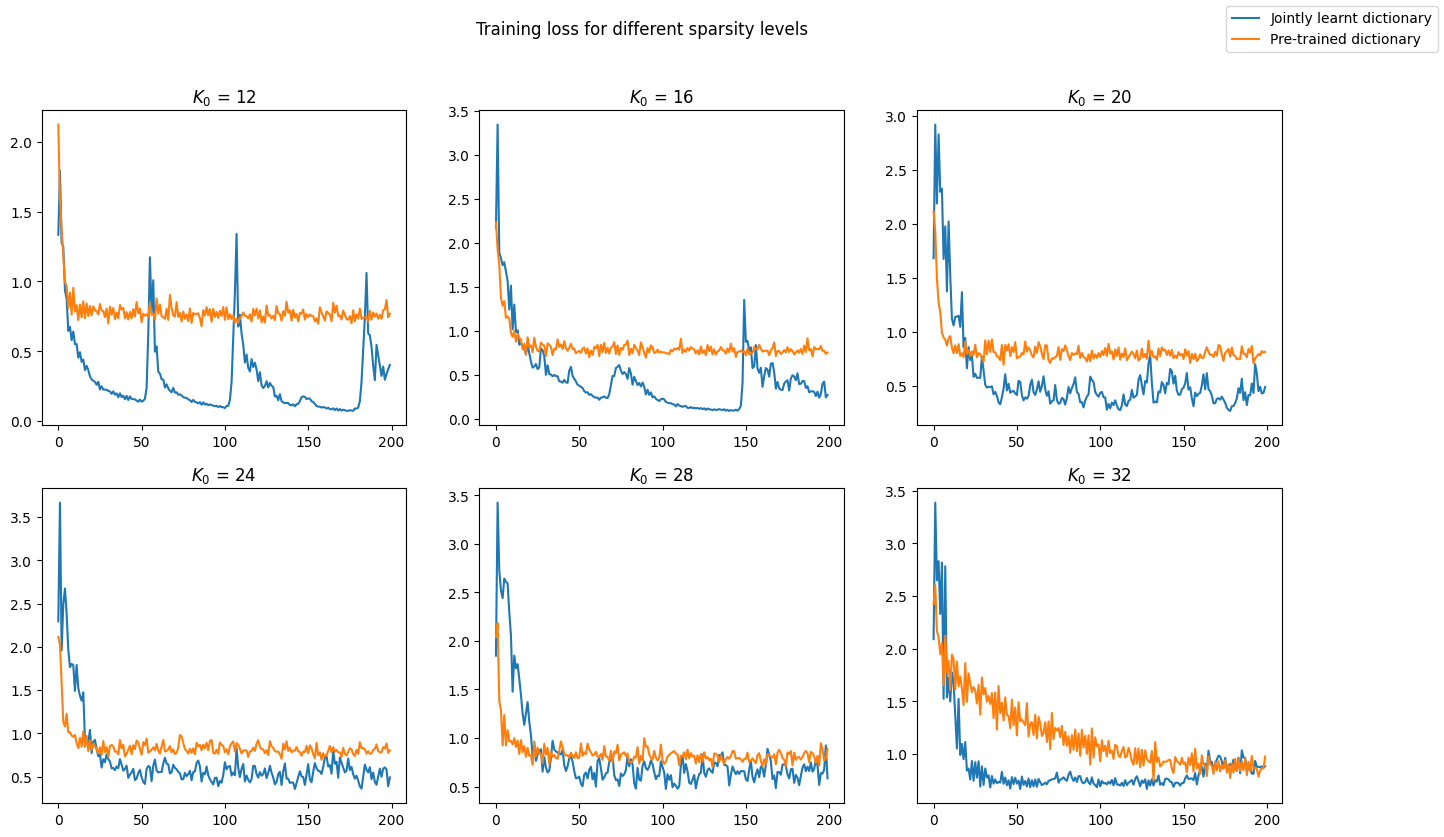

In [8]:
fig, axs = plt.subplots(2, 3, figsize = (16,9))
fig.suptitle('Training loss for different sparsity levels')
for i, k in enumerate(Ks):
    axs[i // 3, i % 3].plot(models_joint[k].train_losses, label = 'Jointly learnt dictionary')
    axs[i // 3, i % 3].plot(models_pre[k].train_losses, label = 'Pre-trained dictionary')
    axs[i // 3, i % 3].set_title(f'$K_0$ = {k}')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)

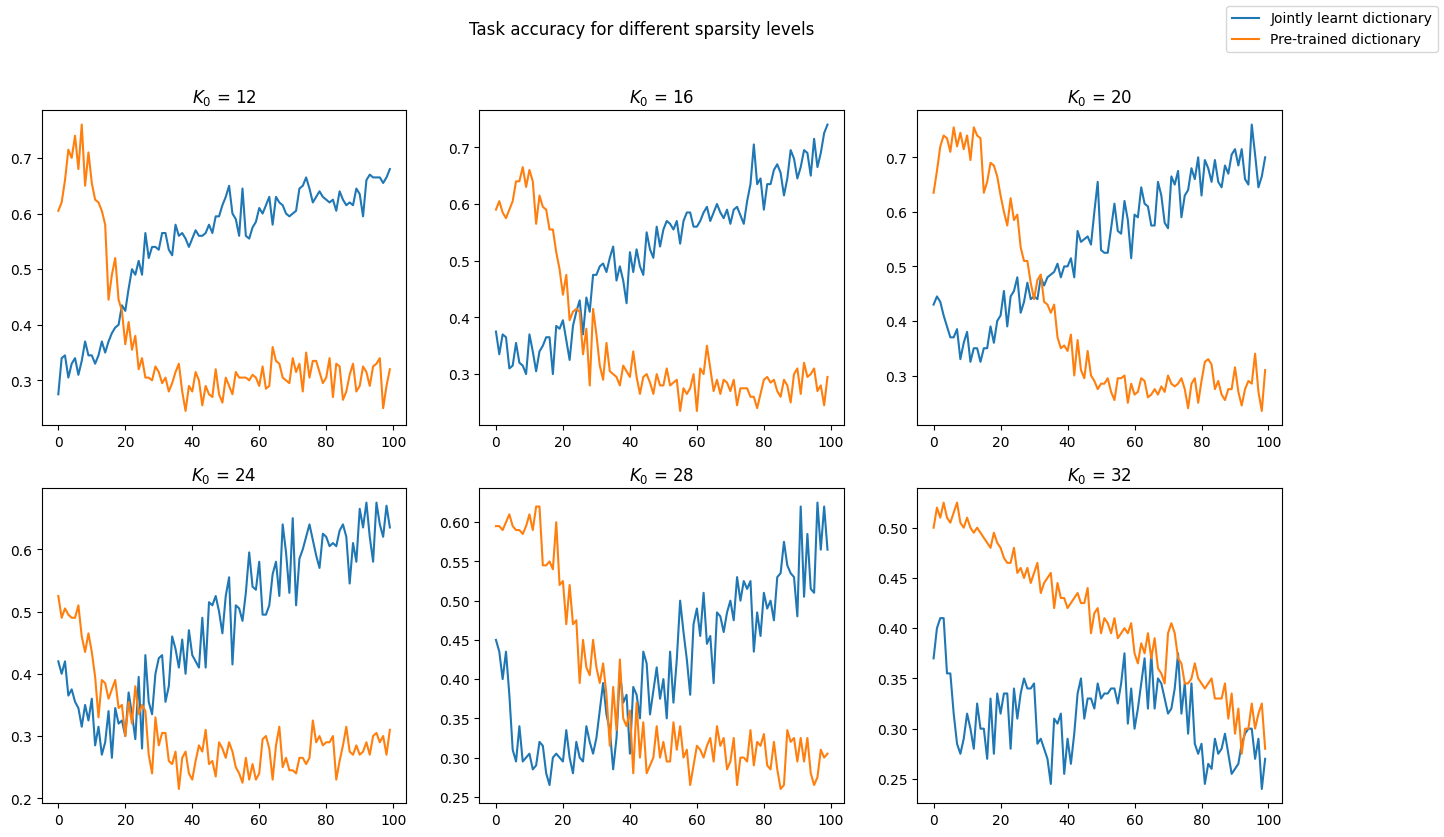

In [9]:
fig, axs = plt.subplots(2, 3, figsize = (16,9))
fig.suptitle('Task accuracy for different sparsity levels')
for i, k in enumerate(Ks):
    axs[i // 3, i % 3].plot(models_joint[k].eval_acc, label = 'Jointly learnt dictionary')
    axs[i // 3, i % 3].plot(models_pre[k].eval_acc, label = 'Pre-trained dictionary')
    axs[i // 3, i % 3].set_title(f'$K_0$ = {k}')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)

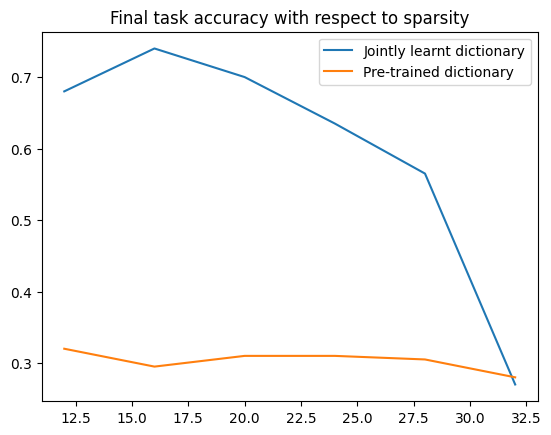

In [10]:
joint_accs = [models_joint[k].eval_acc[len(models_joint[k].eval_acc)-1] for k in Ks]
pre_accs = [models_pre[k].eval_acc[len(models_pre[k].eval_acc)-1] for k in Ks]

plt.plot(Ks, joint_accs, label = 'Jointly learnt dictionary')
plt.plot(Ks, pre_accs, label = 'Pre-trained dictionary')
plt.title('Final task accuracy with respect to sparsity')
plt.legend()

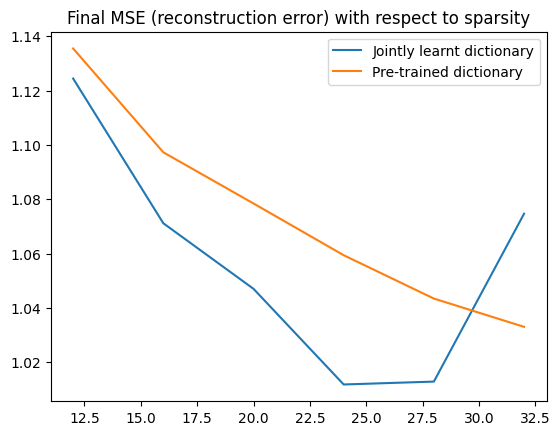

In [11]:
joint_MSE = [models_joint[k].eval_losses[len(models_joint[k].eval_losses)-1].item() for k in Ks]
pre_MSE = [models_pre[k].eval_losses[len(models_pre[k].eval_acc)-1].item() for k in Ks]

plt.plot(Ks, joint_MSE, label = 'Jointly learnt dictionary')
plt.plot(Ks, pre_MSE, label = 'Pre-trained dictionary')
plt.title('Final MSE (reconstruction error) with respect to sparsity')
plt.legend()

### New models with random sparsity

In [12]:
Ks = [12,16,20,24,28,32]

random_models_joint = {k : None for k in Ks}
random_models_pre = {k : None for k in Ks}

for k in Ks:
    model1 = TDDL(m_, n_, k, train_set, sparsity_mode='Random', T = 100, LR = 5e-2)
    model1.trainLoop(train_set, test_set)

    model2 = TDDL(m_, n_, k, train_set, dicup = False, sparsity_mode = 'Random', burn_in=100, T = 100, LR = 5e-2)
    model2.trainLoop(train_set, test_set)

    random_models_joint[k] = model1
    random_models_pre[k] = model2

100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


In [13]:
with open('random_joint_models.pkl', 'wb') as handle:
    pickle.dump(random_models_joint, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('random_pre_models.pkl', 'wb') as handle:
    pickle.dump(random_models_pre, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('random_joint_models.pkl', 'rb') as file:
    random_models_joint = pickle.load(file)

with open('random_pre_models.pkl', 'rb') as file:
    random_models_pre = pickle.load(file)

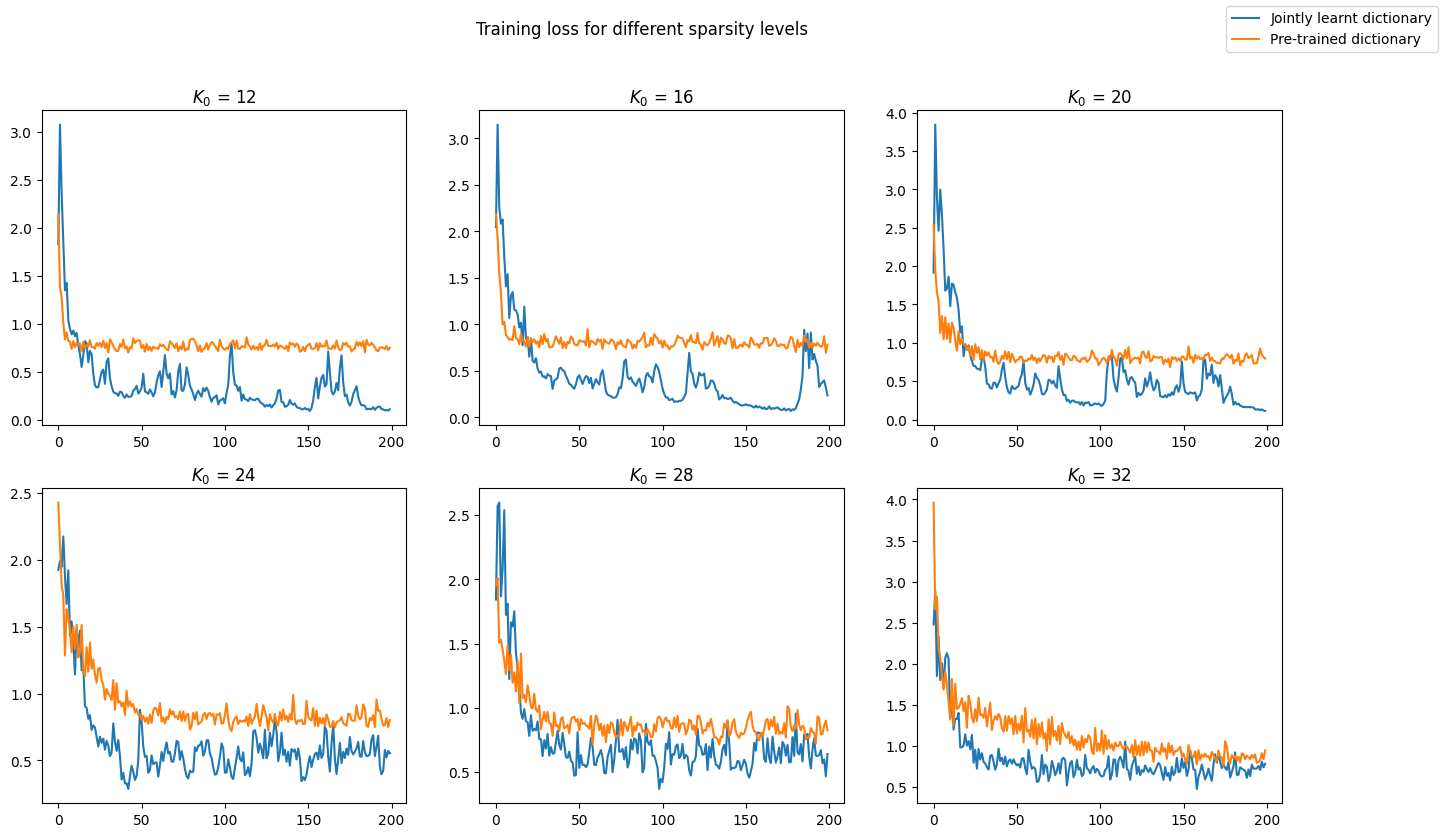

In [15]:
fig, axs = plt.subplots(2, 3, figsize = (16,9))
fig.suptitle('Training loss for different sparsity levels')
for i, k in enumerate(Ks):
    axs[i // 3, i % 3].plot(random_models_joint[k].train_losses, label = 'Jointly learnt dictionary')
    axs[i // 3, i % 3].plot(random_models_pre[k].train_losses, label = 'Pre-trained dictionary')
    axs[i // 3, i % 3].set_title(f'$K_0$ = {k}')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)

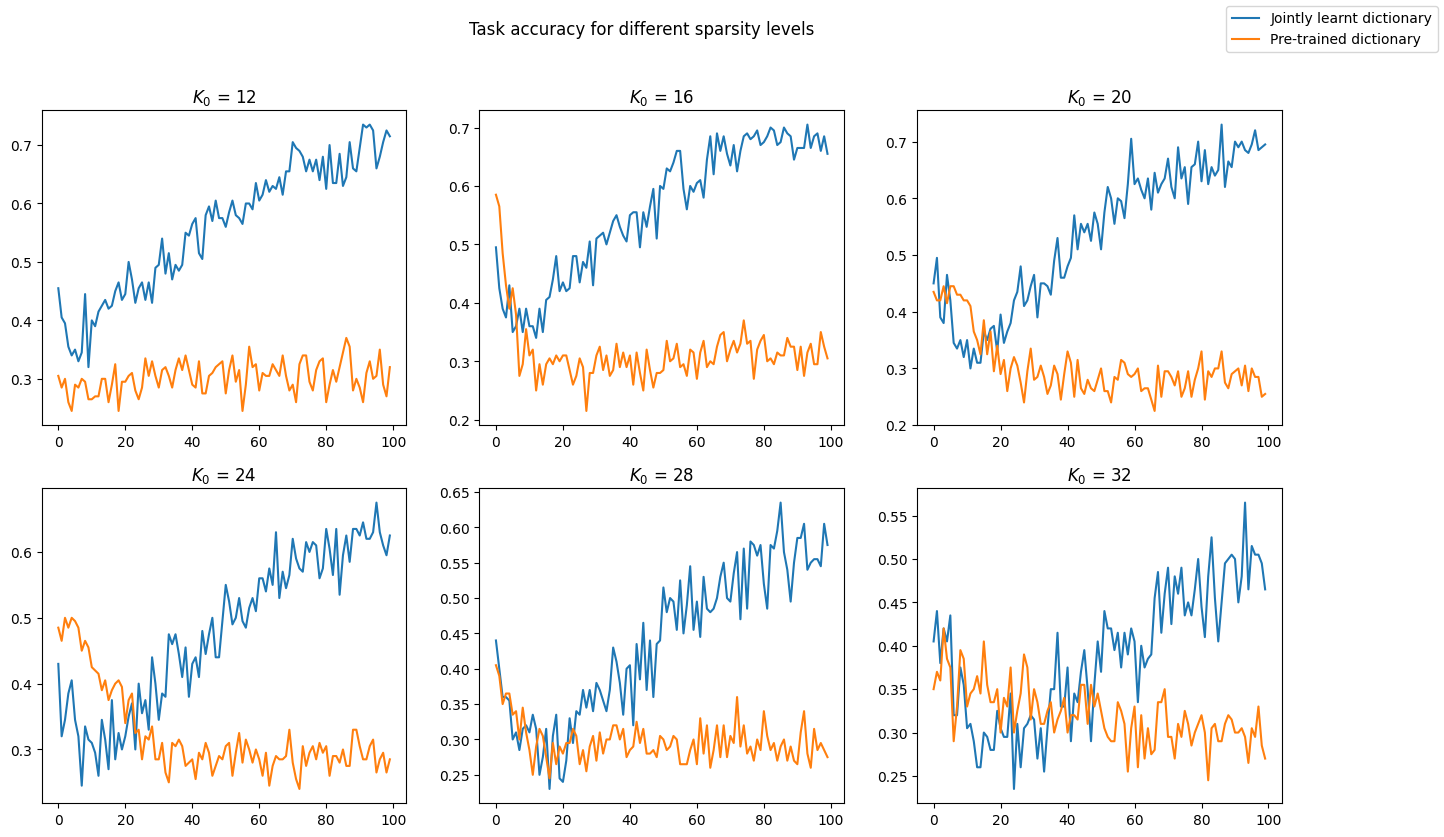

In [16]:
fig, axs = plt.subplots(2, 3, figsize = (16,9))
fig.suptitle('Task accuracy for different sparsity levels')
for i, k in enumerate(Ks):
    axs[i // 3, i % 3].plot(random_models_joint[k].eval_acc, label = 'Jointly learnt dictionary')
    axs[i // 3, i % 3].plot(random_models_pre[k].eval_acc, label = 'Pre-trained dictionary')
    axs[i // 3, i % 3].set_title(f'$K_0$ = {k}')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels)

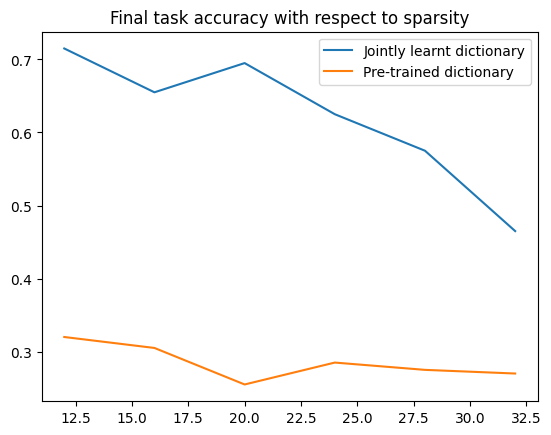

In [17]:
random_joint_accs = [random_models_joint[k].eval_acc[len(models_joint[k].eval_acc)-1] for k in Ks]
random_pre_accs = [random_models_pre[k].eval_acc[len(models_pre[k].eval_acc)-1] for k in Ks]

plt.plot(Ks, random_joint_accs, label = 'Jointly learnt dictionary')
plt.plot(Ks, random_pre_accs, label = 'Pre-trained dictionary')
plt.title('Final task accuracy with respect to sparsity')
plt.legend()

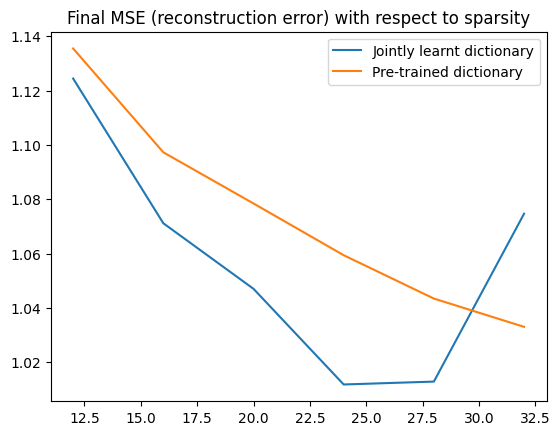

In [18]:
random_joint_MSE = [random_models_joint[k].eval_losses[len(random_models_joint[k].eval_losses)-1].item() for k in Ks]
random_pre_MSE = [random_models_pre[k].eval_losses[len(random_models_pre[k].eval_losses)-1].item() for k in Ks]

plt.plot(Ks, joint_MSE, label = 'Jointly learnt dictionary')
plt.plot(Ks, pre_MSE, label = 'Pre-trained dictionary')
plt.title('Final MSE (reconstruction error) with respect to sparsity')
plt.legend()

_________

### Legacy methods

In [19]:
'''
    def LARS(self, X):

        # Use LARS for sparse coding
        lars = Lars(n_nonzero_coefs=self.K)

        alpha_hat = torch.zeros(X.shape[0], self.D.shape[1])
        
        for i in range(X.shape[0]):
            lars.fit(self.D.detach().cpu().numpy(), X[i].detach().cpu().numpy())
            alpha_hat[i, :] = torch.tensor(lars.coef_, device=X.device)

        return alpha_hat.requires_grad_(True)

    def IST(self, X, max_itr = 100):

        alpha_hat = torch.zeros(X.shape[0], self.D.shape[1])
        L = float(torch.linalg.eigvalsh(self.D.t() @ self.D)[-1].item())
        proj = nn.Softshrink(lambd = self.Lambda / L)

        for _ in range(max_itr):

            alpha_tilde = alpha_hat - 1/L * ((self.D.T @ (alpha_hat @ self.D.T - X).T).T + self.Lambda_2 * alpha_hat)
            alpha_hat = proj(alpha_tilde)

        return torch.tensor(alpha_hat, requires_grad=True)

    def OMP(self, X):
        batch_size = X.shape[0]
        S = [[] for _ in range(batch_size)]
        alpha = torch.zeros((batch_size, self.D.shape[1]))
        R = X.clone()
        
        for _ in range(self.K):

            correlations = torch.abs(torch.matmul(R, self.D))

            for i in range(batch_size):

                correlations[i,S[i]] = -torch.inf
                selected_atoms = torch.argmax(correlations[i,:])

                S[i].append(selected_atoms.item())
                dic = self.D[:, S[i]]

                x_S = torch.linalg.inv(dic.t() @ dic) @ dic.t() @ X[i]
                alpha[i, S[i]] = x_S
                R[i] = X[i] - torch.matmul(self.D, alpha[i])
        
        return torch.tensor(alpha, requires_grad=True)
    '''


'\n    def LARS(self, X):\n\n        # Use LARS for sparse coding\n        lars = Lars(n_nonzero_coefs=self.K)\n\n        alpha_hat = torch.zeros(X.shape[0], self.D.shape[1])\n        \n        for i in range(X.shape[0]):\n            lars.fit(self.D.detach().cpu().numpy(), X[i].detach().cpu().numpy())\n            alpha_hat[i, :] = torch.tensor(lars.coef_, device=X.device)\n\n        return alpha_hat.requires_grad_(True)\n\n    def IST(self, X, max_itr = 100):\n\n        alpha_hat = torch.zeros(X.shape[0], self.D.shape[1])\n        L = float(torch.linalg.eigvalsh(self.D.t() @ self.D)[-1].item())\n        proj = nn.Softshrink(lambd = self.Lambda / L)\n\n        for _ in range(max_itr):\n\n            alpha_tilde = alpha_hat - 1/L * ((self.D.T @ (alpha_hat @ self.D.T - X).T).T + self.Lambda_2 * alpha_hat)\n            alpha_hat = proj(alpha_tilde)\n\n        return torch.tensor(alpha_hat, requires_grad=True)\n\n    def OMP(self, X):\n        batch_size = X.shape[0]\n        S = [[] for 